# CS421: Introduction to Machine Learning
## Project: Predicting Credit Card Customer Churn
### Performance Evaluation
---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

y_train = df_train[["attrition_flag"]]
x_train = df_train.drop("attrition_flag", axis=1)

y_test = df_test[["attrition_flag"]]
x_test = df_test.drop("attrition_flag", axis=1)

In [4]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def build_model(model):
    global x_train
    global y_train
    
    smote_sampler = SMOTE(random_state=2021)

    scale_features = x_train.columns[1:]

    scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ])

    pipeline = Pipeline(steps = [['scaler', scaler],
                                 ['smote', smote_sampler],
                                 ['classifier', model]])

    pipeline.fit(x_train, y_train.values.ravel() )

    y_pred = pipeline.predict(x_test)
    
    return y_pred

In [5]:
from sklearn.metrics import recall_score, fbeta_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

def display_metrics(model_name, y_pred):
    print(f"-----------------------PERFORMANCE EVALUATION: {model_name}--------------------  ")
    print(f"Recall: {recall_score(y_test, y_pred)} ")
    print(f"Fbeta2: {fbeta_score(y_test, y_pred, beta=2)} ")
    print(f"AUC Score: {roc_auc_score(y_test, y_pred)} ")
    
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Existing Customer', 'Attrited Customer']

    diagram = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    diagram.plot(cmap=plt.cm.Blues)
    plt.show()

# 1. RandomForest
---

-----------------------PERFORMANCE EVALUATION: Random Forest--------------------  
Recall: 0.8584615384615385 
Fbeta2: 0.8323389021479715 
AUC Score: 0.9007181296070186 


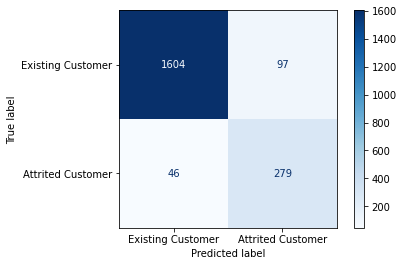

In [5]:
rf_clf = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=8,
                                    min_samples_split=2, n_estimators=125,
                                    random_state=2021)

rf_ypred = build_model(rf_clf)
display_metrics('Random Forest', rf_ypred)

# 2. Logistic Regression
---

-----------------------PERFORMANCE EVALUATION: Logistic Regression--------------------  
Recall: 0.7169230769230769 
Fbeta2: 0.6328082563824009 
AUC Score: 0.76792655903767 


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


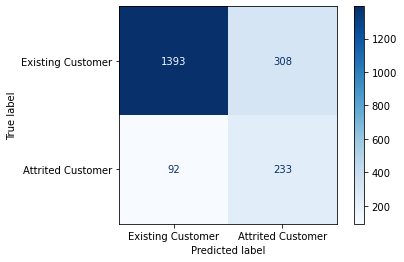

In [7]:
lr_clf = LogisticRegression(
    C=0.5,
    fit_intercept=True,
    max_iter=10,
    multi_class='auto',
    penalty='l2',
    solver='sag',
    random_state=2021
)

lr_ypred = build_model(lr_clf)
display_metrics('Logistic Regression', lr_ypred)

